# Imports

In [1]:
import sys
import math
import statistics
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import *
from decimal import Decimal
from IPython.display import Image
from matplotlib import pyplot as plt

sys.path.insert(0, '/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm')
from viz_preprocess import *
from viz_sequence import *

plt.style.use('default')
pd.set_option('display.max_columns', None)

# Quick Links

<ol>
    <li><a href=#find_motif>Motif Discovery</a></li>
    <li><a href=#score_dist>Score Distribution</a></li>
    <li><a href=#sig_snps>Significant SNPs</a></li>
    <li><a href=#neg_snps>Negative Scoring SNPs</a></li>
    <li><a href=#pos_snps>Positive Scoring SNPs</a></li>
    <li><a href=#final_table>Final SNP Table</a></li>
</ol>

## Choose Cluster

In [2]:
cluster_input = 8

# Prepare Scores

In [3]:
cluster = str(cluster_input)
effect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                +cluster+'.effect.fasta'
effect_seqs = [x.rstrip() for (i,x) in enumerate(open(effect_fasta)) if i%2==1]
effect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in effect_seqs]

print()
print("Num effect sequences:", '\t', '\t', len(effect_onehot))

merged_effect_scores = np.zeros(shape=(len(effect_onehot), 1000, 4))

for fold in range(10):
    effect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                    +cluster+'/fold'+str(fold)+'.effect.scores.txt'
    effect_scores = get_hyp_scores(effect_file, effect_seqs)
    effect_scores = np.array(effect_scores)
    merged_effect_scores = merged_effect_scores + effect_scores
    
merged_effect_scores = merged_effect_scores / (fold + 1)

#--------------------------------------------------------#

noneffect_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/Cluster' \
                    +cluster+'.noneffect.fasta'
noneffect_seqs = [x.rstrip() for (i,x) in enumerate(open(noneffect_fasta)) if i%2==1]
noneffect_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in noneffect_seqs]

print("Num noneffect sequences:", '\t', len(noneffect_onehot))

merged_noneffect_scores = np.zeros(shape=(len(noneffect_onehot), 1000, 4))

for fold in range(10):
    noneffect_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/Cluster' \
                        +cluster+'/fold'+str(fold)+'.noneffect.scores.txt'
    noneffect_scores = get_hyp_scores(noneffect_file, noneffect_seqs)
    noneffect_scores = np.array(noneffect_scores)
    merged_noneffect_scores = merged_noneffect_scores + noneffect_scores
    
merged_noneffect_scores = merged_noneffect_scores / (fold + 1)

#--------------------------------------------------------#

print("Num scores:", '\t', '\t', '\t', len(noneffect_onehot))

merged_ism_scores = np.zeros(shape=(len(effect_onehot),))
merged_delta_scores = np.zeros(shape=(len(effect_onehot),))

for fold in range(10):
    ism_scores = np.array([float(i.strip().split('\t')[1]) \
                           for i in open('/mnt/lab_data3/soumyak/adpd/ism_scores/Cluster'
                                         +cluster+'/fold'+str(fold)+'.ism.scores').readlines()])
    delta_scores = np.array([float(i.strip().split('\t')[1]) \
                             for i in open('/mnt/lab_data3/soumyak/adpd/delta_scores/Cluster'
                                           +cluster+'/fold'+str(fold)+'.delta.scores').readlines()])
    merged_ism_scores = merged_ism_scores + ism_scores
    merged_delta_scores = merged_delta_scores + delta_scores
        
merged_ism_scores = merged_ism_scores / (fold + 1)
merged_delta_scores = merged_delta_scores / (fold + 1)


Num effect sequences: 	 	 202
Num noneffect sequences: 	 202
Num scores: 	 	 	 202


# Model the Distribution of Importance Scores <a name='find_motif' />

In [4]:
sig_list = []
ksvals = []
motifs = []
motif_others = []

for seq in range(len(effect_onehot)):
    if merged_ism_scores[seq] >= 0:
        scores = [np.sum(j) for j in merged_effect_scores[seq][400:600]]
    else:
        scores = [np.sum(j) for j in merged_noneffect_scores[seq][400:600]]
    shape, mean, stdev = t.fit(scores)
    kstat, kval = stats.kstest(scores, 't', args=[shape, mean, stdev])
    if merged_ism_scores[seq] >= 0:
        pvals = t.cdf([np.sum(j) for j in merged_effect_scores[seq]], shape, mean, stdev)
    else:
        pvals = t.cdf([np.sum(j) for j in merged_noneffect_scores[seq]], shape, mean, stdev)
    ksvals.append([kstat, kval])
    
    start = 499
    end = 499
    while True:
        if pvals[start - 1] <= 0.95:
            if pvals[start - 2] <= 0.95:
                break
            else:
                start -= 1
        else:
            start -= 1
    while True:
        if pvals[end] <= 0.95:
            if pvals[end + 1] <= 0.95:
                break
            else:
                end += 1
        else:
            end += 1

    if merged_ism_scores[seq] >= 0:
        if start != end:
            motif = effect_seqs[seq][start:end]
            motif_other = noneffect_seqs[seq][start:end]
            motif_len = len(motif)
            if motif_len < 7:
                mstart = start - math.floor((10 - motif_len) / 2)
                mend = end + math.ceil((10 - motif_len) / 2)
                motif = effect_seqs[seq][mstart:mend]
                motif_other = noneffect_seqs[seq][mstart:mend]
            else:
                mstart = start
                mend = end
        else:
            mstart = start - 4
            mend = end + 6
            motif = effect_seqs[seq][mstart:mend]
            motif_other = noneffect_seqs[seq][mstart:mend]
    else:
        if start != end:
            motif = noneffect_seqs[seq][start:end]
            motif_other = effect_seqs[seq][start:end]
            motif_len = len(motif)
            if motif_len < 7:
                mstart = start - math.floor((10 - motif_len) / 2)
                mend = end + math.ceil((10 - motif_len) / 2)
                motif = noneffect_seqs[seq][mstart:mend]
                motif_other = effect_seqs[seq][mstart:mend]
            else:
                mstart = start
                mend = end
                
        else:
            mstart = start - 4
            mend = end + 6
            motif = noneffect_seqs[seq][mstart:mend]
            motif_other = effect_seqs[seq][mstart:mend]
    
    motifs.append(motif)
    motif_others.append(motif_other)
    sig_list.append([start, end, shape, mean, stdev, mstart, mend])

sig_list_stats = [x[1]-x[0] for x in sig_list if x[1]-x[0] != 0]
all_list_stats = [len(x) for x in motifs]
ksvals_pvals = [x[1] for x in ksvals]
sig_ksvals = [x for x in ksvals_pvals if x < 0.01]
print()
print('Mean KS-test p-value:', '\t', '\t', statistics.mean(ksvals_pvals))
print('Median KS-test p-value:', '\t', statistics.median(ksvals_pvals))
print('St. Dev KS-test p-value:', '\t', statistics.stdev(ksvals_pvals))
print('Max KS-test p-value:', '\t', '\t', max(ksvals_pvals))
print('Min KS-test p-value:', '\t', '\t', min(ksvals_pvals))
print('Num significant p-values:', '\t', len(sig_ksvals))
print()
print('Mean non-zero motif length:', '\t', statistics.mean(sig_list_stats))
print('Median non-zero motif length:', '\t', statistics.median(sig_list_stats))
print('St. Dev non-zero motif length:', '\t', statistics.stdev(sig_list_stats))
#print('Mode non-zero motif length:', '\t', statistics.mode(sig_list_stats))
print('Max non-zero motif length:', '\t', max(sig_list_stats))
print('Min non-zero motif lenght:', '\t', min(sig_list_stats))
print()
print('Mean motif length:', '\t', '\t', statistics.mean(all_list_stats))
print('Median motif length:', '\t', '\t', statistics.median(all_list_stats))
print('St. Dev motif length:', '\t', '\t', statistics.stdev(all_list_stats))
#print('Mode motif length:', '\t', '\t', statistics.mode(all_list_stats))
print('Max motif length:', '\t', '\t', max(all_list_stats))
print('Min motif lenght:', '\t', '\t', min(all_list_stats))


Mean KS-test p-value: 	 	 0.4491916301126248
Median KS-test p-value: 	 0.43393782798926195
St. Dev KS-test p-value: 	 0.32125640639883246
Max KS-test p-value: 	 	 0.999074959594602
Min KS-test p-value: 	 	 3.842681579271522e-11
Num significant p-values: 	 14

Mean non-zero motif length: 	 10.127450980392156
Median non-zero motif length: 	 10.0
St. Dev non-zero motif length: 	 5.924728457874967
Max non-zero motif length: 	 26
Min non-zero motif lenght: 	 1

Mean motif length: 	 	 10.94059405940594
Median motif length: 	 	 10.0
St. Dev motif length: 	 	 3.22867063560196
Max motif length: 	 	 26
Min motif lenght: 	 	 7


# Prepare DataFrame

In [5]:
snps = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/Cluster'
                   +cluster+'.overlap.expanded.snps.hg38.bed', sep='\t')
ryan_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                        +'snps_final/191023_All_GWAS_SNPs_unique.csv', sep='\t')
mike_snps = pd.read_csv('/oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/'
                        +'snps_final/ld_buddies_table_stage3.tsv', sep='\t')

effect_center = []
noneffect_center = []
effect_ratio = []
noneffect_ratio = []
orig_score = []
diff_score = []
ratio_score = []
ism_score = []
delta_score = []
idr_peak = []
gwas = []
gwas_pval = []
coloc = []

for index,row in snps.iterrows():
    
    orig_eff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_effect_scores[index][475:525]]))
    eff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_effect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    eff_cent_nonzero = np.sum(np.array([max(0, np.sum(j)) \
                                        for j in \
                                        merged_effect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    effect_center.append(eff_cent)
    
    orig_noneff_cent = np.sum(np.array([np.sum(j) \
                                for j in \
                                merged_noneffect_scores[index][475:525]]))
    noneff_cent = np.sum(np.array([np.sum(j) \
                                   for j in \
                                   merged_noneffect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    noneff_cent_nonzero = np.sum(np.array([max(0, np.sum(j)) \
                                           for j in \
                                           merged_noneffect_scores[index][sig_list[index][0]:sig_list[index][1]]]))
    noneffect_center.append(noneff_cent)
    
    eff_bg = np.sum(np.array([max(0, np.sum(j)) \
                              for j in merged_effect_scores[index][400:600]]))
    eff_rat = eff_cent_nonzero / eff_bg
    effect_ratio.append(eff_rat)
    
    noneff_bg = np.sum(np.array([max(0, np.sum(j)) \
                                 for j in merged_noneffect_scores[index][400:600]]))
    noneff_rat = noneff_cent_nonzero / noneff_bg
    noneffect_ratio.append(noneff_rat)
    
    orig_score.append(orig_eff_cent - orig_noneff_cent)
    if (sig_list[index][1] - sig_list[index][0]) > 0:
        diff_score.append(eff_cent_nonzero - noneff_cent_nonzero)
        ratio_score.append(eff_rat - noneff_rat)
    else:
        diff_score.append('NAN')
        ratio_score.append('NAN')
    
    idr_peak_overlap = False
    for ind,rw in ryan_snps.loc[ryan_snps['rsid']==row['rsid']].iterrows():
        if rw['Cluster'+cluster+'_overlap'] == 1:
            idr_peak_overlap = True
    idr_peak.append(idr_peak_overlap)
    gwas_list = []
    has_coloc = False
    lowest_pval = 1
    for ind,rw in mike_snps.loc[mike_snps['rsid']==row['rsid']].iterrows():
        if rw['has_coloc'] == True:
            has_coloc = True
        if rw['pvalue'] < lowest_pval:
            gwas_list = rw['source_gwas']
            lowest_pval = rw['pvalue']
    gwas.append(gwas_list)
    gwas_pval.append(lowest_pval)
    coloc.append(has_coloc)

snps.effect.replace('NAN', 'Z', inplace=True)
snps.noneffect.replace('NAN', 'Z', inplace=True)
snps['effect_center'] = effect_center
snps['noneffect_center'] = noneffect_center
snps['effect_ratio'] = effect_ratio
snps['noneffect_ratio'] = noneffect_ratio
snps['orig_score'] = orig_score
snps['diff_score'] = diff_score
snps['ratio_score'] = ratio_score
snps['ism_score'] = merged_ism_scores
snps['delta_score'] = merged_delta_scores
snps['gwas'] = gwas
snps['gwas_pval'] = gwas_pval
snps['coloc'] = coloc
snps['idr_peak'] = idr_peak
snps['motif'] = motifs
snps['motif_other'] = motif_others
snps.drop(['source_gwas','pvalue','ld_tag_chr','ld_tag_pos','r2_with_ld_tag'], axis=1, inplace=True)
snps.sort_values(by=['rsid', 'effect'], ascending=True, inplace=True)
snps.drop_duplicates(subset=['rsid'], inplace=True)
snps.effect.replace('Z', 'NAN', inplace=True)
snps.noneffect.replace('Z', 'NAN', inplace=True)
print()
print('Number of Unique SNPs:', len(snps))

/users/soumyak/miniconda3/envs/dragonn/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



Number of Unique SNPs: 183


## Distribution of Original gkmExplain Scores <a name='score_dist' />


Number of SNPs with significant motifs: 183


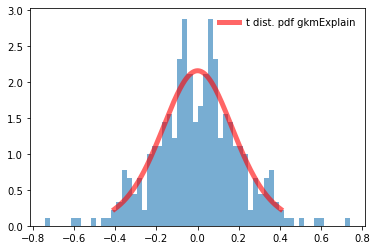

In [6]:
true_orig_scores = snps.orig_score.tolist()
true_orig_scores = [i for i in true_orig_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_orig_scores))
oppo_orig_scores = [-1 * i for i in true_orig_scores]
orig_scores = true_orig_scores + oppo_orig_scores
orig_shape, orig_mean, orig_stdev = t.fit(orig_scores)
fig, ax = plt.subplots(1, 1)
orig_x = np.linspace(t.ppf(0.025, orig_shape, orig_mean, orig_stdev),
                t.ppf(0.975, orig_shape, orig_mean, orig_stdev), 1000)
ax.plot(orig_x, t.pdf(orig_x, orig_shape, orig_mean, orig_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(orig_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for Original gkmExplain Scores

In [7]:
print()
print('Shape:', '\t', orig_shape)
print('Mean:', '\t', orig_mean)
print('Stdev:', '\t', orig_stdev)
print()
print(stats.kstest(orig_scores, 't', args=[orig_shape, orig_mean, orig_stdev]))


Shape: 	 9.591897817421742
Mean: 	 -6.755153862204943e-08
Stdev: 	 0.18009216375751746

KstestResult(statistic=0.023636548797980272, pvalue=0.9867106877074924)


## Distribution of Non-Zero Difference gkmExplain Scores


Number of SNPs with significant motifs: 93


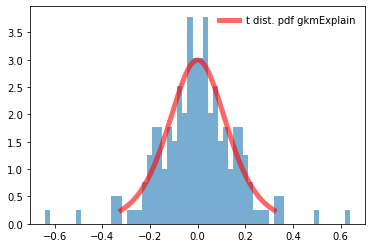

In [8]:
true_diff_scores = snps.diff_score.tolist()
true_diff_scores = [i for i in true_diff_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_diff_scores))
oppo_diff_scores = [-1 * i for i in true_diff_scores]
diff_scores = true_diff_scores + oppo_diff_scores
diff_shape, diff_mean, diff_stdev = t.fit(diff_scores)
fig, ax = plt.subplots(1, 1)
diff_x = np.linspace(t.ppf(0.025, diff_shape, diff_mean, diff_stdev),
                t.ppf(0.975, diff_shape, diff_mean, diff_stdev), 1000)
ax.plot(diff_x, t.pdf(diff_x, diff_shape, diff_mean, diff_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(diff_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## KS-test for Non-Zero Difference gkmExplain Scores

In [9]:
print()
print('Shape:', '\t', diff_shape)
print('Mean:', '\t', diff_mean)
print('Stdev:', '\t', diff_stdev)
print()
print(stats.kstest(diff_scores, 't', args=[diff_shape, diff_mean, diff_stdev]))


Shape: 	 5.261303206504252
Mean: 	 -4.4312041598834026e-08
Stdev: 	 0.12707034272228407

KstestResult(statistic=0.03163247191247004, pvalue=0.9923197033136593)


## Distribution of Ratio Difference gkmExplain Scores


Number of SNPs with significant motifs: 93


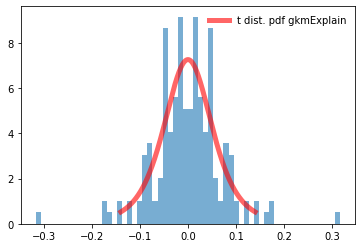

In [10]:
true_ratio_scores = snps.ratio_score.tolist()
true_ratio_scores = [i for i in true_ratio_scores if i != 'NAN']
print()
print('Number of SNPs with significant motifs:', len(true_ratio_scores))
oppo_ratio_scores = [-1 * i for i in true_ratio_scores]
ratio_scores = true_ratio_scores + oppo_ratio_scores
ratio_shape, ratio_mean, ratio_stdev = t.fit(ratio_scores)
fig, ax = plt.subplots(1, 1)
ratio_x = np.linspace(t.ppf(0.025, ratio_shape, ratio_mean, ratio_stdev),
                t.ppf(0.975, ratio_shape, ratio_mean, ratio_stdev), 1000)
ax.plot(ratio_x, t.pdf(ratio_x, ratio_shape, ratio_mean, ratio_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf gkmExplain')
ax.hist(ratio_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## KS-test for Ratio Difference gkmExplain Scores

In [11]:
print()
print('Shape:', '\t', ratio_shape)
print('Mean:', '\t', ratio_mean)
print('Stdev:', '\t', ratio_stdev)
print()
print(stats.kstest(ratio_scores, 't', args=[ratio_shape, ratio_mean, ratio_stdev]))


Shape: 	 4.329583389187404
Mean: 	 1.1713484258800456e-07
Stdev: 	 0.05190289301752131

KstestResult(statistic=0.03575497869435462, pvalue=0.971308471139896)


## Distribution of ISM Scores

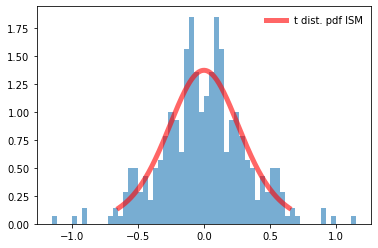

In [12]:
true_ism_scores = snps.ism_score.tolist()
oppo_ism_scores = [-1 * i for i in true_ism_scores]
ism_scores = true_ism_scores + oppo_ism_scores
ism_shape, ism_mean, ism_stdev = t.fit(ism_scores)
fig, ax = plt.subplots(1, 1)
ism_x = np.linspace(t.ppf(0.025, ism_shape, ism_mean, ism_stdev),
                t.ppf(0.975, ism_shape, ism_mean, ism_stdev), 1000)
ax.plot(ism_x, t.pdf(ism_x, ism_shape, ism_mean, ism_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf ISM')
ax.hist(ism_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for ISM Scores

In [13]:
print()
print('Shape:', '\t', ism_shape)
print('Mean:', '\t', ism_mean)
print('Stdev:', '\t', ism_stdev)
print()
print(stats.kstest(ism_scores, 't', args=[ism_shape, ism_mean, ism_stdev]))


Shape: 	 8.60194874003203
Mean: 	 -1.8405539137993118e-07
Stdev: 	 0.2829201450316902

KstestResult(statistic=0.028181732863034825, pvalue=0.9332947671222184)


## Distribution of Delta Scores

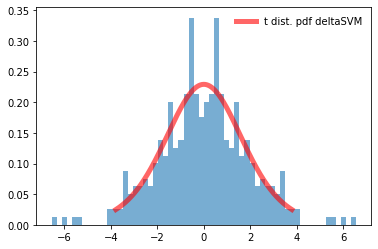

In [14]:
true_delta_scores = snps.delta_score.tolist()
oppo_delta_scores = [-1 * i for i in true_delta_scores]
delta_scores = true_delta_scores + oppo_delta_scores
delta_shape, delta_mean, delta_stdev = t.fit(delta_scores)
fig, ax = plt.subplots(1, 1)
delta_x = np.linspace(t.ppf(0.025, delta_shape, delta_mean, delta_stdev),
                t.ppf(0.975, delta_shape, delta_mean, delta_stdev), 1000)
ax.plot(delta_x, t.pdf(delta_x, delta_shape, delta_mean, delta_stdev), 'r-', lw=5,
        alpha=0.6, label='t dist. pdf deltaSVM')
ax.hist(delta_scores, density=True, histtype='stepfilled',
        alpha=0.6, bins=60)
ax.legend(loc='best', frameon=False)
plt.show()

## Kolmogorov-Smirnov test (KS-test) for Delta Scores

In [15]:
print()
print('Shape:', '\t', delta_shape)
print('Mean:', '\t', delta_mean)
print('Stdev:', '\t', delta_stdev)
print()
print(stats.kstest(delta_scores, 't', args=[delta_shape, delta_mean, delta_stdev]))


Shape: 	 9.866828229077552
Mean: 	 -8.532513216914991e-07
Stdev: 	 1.6967926665982234

KstestResult(statistic=0.028908538399097905, pvalue=0.9197177967201667)


# Get Significant SNPs

In [16]:
pd.set_option('mode.chained_assignment', None)

snps.orig_score.replace('NAN', 0.0, inplace=True)
snps.diff_score.replace('NAN', 0.0, inplace=True)
snps.ratio_score.replace('NAN', 0.0, inplace=True)

orig_pval = [2 * min(t.cdf(x, orig_shape, orig_mean, orig_stdev),
                        1 - t.cdf(x, orig_shape, orig_mean, orig_stdev)) \
                for x in snps['orig_score']]

diff_pval = [2 * min(t.cdf(x, diff_shape, diff_mean, diff_stdev),
                        1 - t.cdf(x, diff_shape, diff_mean, diff_stdev)) \
                for x in snps['diff_score']]

ratio_pval = [2 * min(t.cdf(x, ratio_shape, ratio_mean, ratio_stdev),
                        1 - t.cdf(x, ratio_shape, ratio_mean, ratio_stdev)) \
                for x in snps['ratio_score']]

ism_pval = [2 * min(t.cdf(x, ism_shape, ism_mean, ism_stdev),
                1 - t.cdf(x, ism_shape, ism_mean, ism_stdev)) \
            for x in snps['ism_score']]

delta_pval = [2 * min(t.cdf(x, delta_shape, delta_mean, delta_stdev),
                1 - t.cdf(x, delta_shape, delta_mean, delta_stdev)) \
            for x in snps['delta_score']]

kstest_pval = [ksvals_pvals[x] for x in snps.index]

snps['orig_pval'] = orig_pval
snps['diff_pval'] = diff_pval
snps['ratio_pval'] = ratio_pval
snps['ism_pval'] = ism_pval
snps['delta_pval'] = delta_pval
snps['kstest_pval'] = kstest_pval

neg_orig_cutoff = t.ppf(0.025, orig_shape, orig_mean, orig_stdev)
neg_diff_cutoff = t.ppf(0.025, diff_shape, diff_mean, diff_stdev)
neg_ratio_cutoff_low = t.ppf(0.1, ratio_shape, ratio_mean, ratio_stdev)
neg_ratio_cutoff_high = t.ppf(0.025, ratio_shape, ratio_mean, ratio_stdev)
neg_ism_cutoff = t.ppf(0.025, ism_shape, ism_mean, ism_stdev)
neg_delta_cutoff = t.ppf(0.025, delta_shape, delta_mean, delta_stdev)

snps.sort_values(by=['ratio_pval'], ascending=True, inplace=True)
neg_snps = snps.loc[(snps['orig_score'] < neg_orig_cutoff)
                    & (snps['ism_score'] < neg_ism_cutoff)
                    & (snps['delta_score'] < neg_delta_cutoff)]

pos_orig_cutoff = t.ppf(0.975, orig_shape, orig_mean, orig_stdev)
pos_diff_cutoff = t.ppf(0.975, diff_shape, diff_mean, diff_stdev)
pos_ratio_cutoff_low = t.ppf(0.9, ratio_shape, ratio_mean, ratio_stdev)
pos_ratio_cutoff_high = t.ppf(0.975, ratio_shape, ratio_mean, ratio_stdev)
pos_ism_cutoff = t.ppf(0.975, ism_shape, ism_mean, ism_stdev)
pos_delta_cutoff = t.ppf(0.975, delta_shape, delta_mean, delta_stdev)

pos_snps = snps.loc[(snps['orig_score'] > pos_orig_cutoff)
                    & (snps['ism_score'] > pos_ism_cutoff)
                    & (snps['delta_score'] > pos_delta_cutoff)]

neg_confidence = [0 for x in range(len(neg_snps))]
pos_confidence = [0 for x in range(len(pos_snps))]

counter = 0
for index, row in neg_snps.iterrows():
    if (row['ratio_score'] < neg_ratio_cutoff_high):
        neg_confidence[counter] = 2
    elif (row['ratio_score'] < neg_ratio_cutoff_low) or (row['diff_score'] < neg_diff_cutoff):
        neg_confidence[counter] = 1
    counter += 1
    
counter = 0
for index, row in pos_snps.iterrows():
    if (row['ratio_score'] > pos_ratio_cutoff_high):
        pos_confidence[counter] = 2
    elif (row['ratio_score'] > pos_ratio_cutoff_low) or (row['diff_score'] > pos_diff_cutoff):
        pos_confidence[counter] = 1
    counter += 1
    
neg_snps['confidence'] = neg_confidence
pos_snps['confidence'] = pos_confidence

# Display Significant SNPs <a name='sig_snps' />

In [17]:
print()
print('Negative Original gkmExplain Cutoff:', '\t', '\t', '\t', neg_orig_cutoff)
print('Negative Non-Zero Difference gkmExplain Cutoff:', '\t', neg_diff_cutoff)
print('Negative Ratio Difference gkmExplain Low Cutoff:', '\t', neg_ratio_cutoff_low)
print('Negative Ratio Difference gkmExplain High Cutoff:', '\t', neg_ratio_cutoff_high)
print('Negative ISM Cutoff:', '\t', '\t', '\t', '\t', '\t', neg_ism_cutoff)
print('Negative deltaSVM Cutoff:', '\t', '\t', '\t', '\t', neg_delta_cutoff)
print()
print('Total SNPs with Negative Scores:', '\t', '\t', '\t', len(neg_snps))
print('Confident SNPs with Negative Scores:', '\t', '\t', '\t', len([i for i in neg_confidence if i > 0]))
print('Highly Confident SNPs with Negative Scores:', '\t', '\t', len([i for i in neg_confidence if i > 1]))
display(neg_snps)

print()
print('Positive Original gkmExplain Cutoff:', '\t', '\t', '\t', pos_orig_cutoff)
print('Positive Non-Zero Difference gkmExplain Cutoff:', '\t', pos_diff_cutoff)
print('Positive Ratio Difference gkmExplain Low Cutoff:', '\t', pos_ratio_cutoff_low)
print('Positive Ratio Difference gkmExplain High Cutoff:', '\t', pos_ratio_cutoff_high)
print('Positive ISM Cutoff:', '\t', '\t', '\t', '\t', '\t', pos_ism_cutoff)
print('Positive deltaSVM Cutoff:', '\t', '\t', '\t', '\t', pos_delta_cutoff)
print()
print('Total SNPs with Positive Scores:', '\t', '\t', '\t', len(pos_snps))
print('Confident SNPs with Positive Scores:', '\t', '\t', '\t', len([i for i in pos_confidence if i > 0]))
print('Highly Confident SNPs with Positive Scores:', '\t', '\t', len([i for i in pos_confidence if i > 1]))
display(pos_snps)


Negative Original gkmExplain Cutoff: 	 	 	 -0.40359667365194674
Negative Non-Zero Difference gkmExplain Cutoff: 	 -0.3218250859194347
Negative Ratio Difference gkmExplain Low Cutoff: 	 -0.0784216682513405
Negative Ratio Difference gkmExplain High Cutoff: 	 -0.13988053984623483
Negative ISM Cutoff: 	 	 	 	 	 -0.6445531504538838
Negative deltaSVM Cutoff: 	 	 	 	 -3.787618667601967

Total SNPs with Negative Scores: 	 	 	 3
Confident SNPs with Negative Scores: 	 	 	 3
Highly Confident SNPs with Negative Scores: 	 	 2


,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,effect_center,noneffect_center,effect_ratio,noneffect_ratio,orig_score,diff_score,ratio_score,ism_score,delta_score,gwas,gwas_pval,coloc,idr_peak,motif,motif_other,orig_pval,diff_pval,ratio_pval,ism_pval,delta_pval,kstest_pval,confidence
148,chr2,127128581,127128582,rs13025717,T,C,C,T,C,T,+,77,0.052993,0.716842,0.067599,0.384747,-0.739378,-0.638798,-0.317148,-1.153298,-6.548412,Alzheimers_Jansen_2018,9.125833e-17,False,True,GCCCCGCCCAA,GCCCTGCCCAA,0.002320,0.003476,0.002794,0.003049,0.003243,0.847303,2
160,chr3,49007333,49007334,rs6781790,T,C,C,T,T,C,+,92,0.133212,0.626864,0.067736,0.246615,-0.614683,-0.492313,-0.178880,-0.968007,-5.631062,Chang_23andMe_Parkinsons,2.349340e-03,False,True,GAGGGCGCTGT,GAGGGTGCTGT,0.007030,0.010611,0.023043,0.008136,0.007906,0.177502,2
128,chr19,45001918,45001919,rs35194062,A,C,C,A,C,A,+,71,0.560666,0.887754,0.171236,0.249083,-0.505740,-0.327088,-0.077847,-0.898862,-5.275862,Alzheimers_Kunkle_2019,2.384000e-14,True,True,GGGGCGGGGC,GGGGCGGGGC,0.019253,0.047473,0.202719,0.011897,0.011247,0.001256,1



Positive Original gkmExplain Cutoff: 	 	 	 0.4035965385488693
Positive Non-Zero Difference gkmExplain Cutoff: 	 0.32182499729535147
Positive Ratio Difference gkmExplain Low Cutoff: 	 0.0784219025210257
Positive Ratio Difference gkmExplain High Cutoff: 	 0.13988077411591995
Positive ISM Cutoff: 	 	 	 	 	 0.644552782343101
Positive deltaSVM Cutoff: 	 	 	 	 3.787616961099323

Total SNPs with Positive Scores: 	 	 	 3
Confident SNPs with Positive Scores: 	 	 	 1
Highly Confident SNPs with Positive Scores: 	 	 1


,chr,start,end,rsid,effect,noneffect,ref,alt,major,minor,direction,locus_num,effect_center,noneffect_center,effect_ratio,noneffect_ratio,orig_score,diff_score,ratio_score,ism_score,delta_score,gwas,gwas_pval,coloc,idr_peak,motif,motif_other,orig_pval,diff_pval,ratio_pval,ism_pval,delta_pval,kstest_pval,confidence
101,chr19,44644418,44644419,rs10426401,G,T,T,G,T,G,-,71,0.278521,-0.019238,0.162705,0.0037,0.447844,0.273591,0.159005,0.714782,4.100634,Alzheimers_Jansen_2018,4.632150e-14,True,True,GGGGCGG,GGGTCGG,0.033097,0.081194,0.033806,0.033537,0.036574,9.662672e-01,2
196,chr8,22604860,22604861,rs3735901,T,C,T,C,T,C,-,125,0.000000,0.000000,0.000000,0.0000,0.579273,0.000000,0.000000,0.909995,5.922105,Chang_23andMe_Parkinsons,5.081120e-02,False,True,CCCCTGCCGC,CCCCCGCCGC,0.009725,1.000000,0.999998,0.011186,0.005939,7.849393e-07,0
198,chr8,27608639,27608640,rs1532276,T,C,T,C,C,T,-,126,0.000000,0.000000,0.000000,0.0000,0.439061,0.000000,0.000000,0.684629,3.954949,Alzheimers_Jansen_2018,4.000015e-19,True,True,CCCATCCAGA,CCCACCCAGA,0.035929,1.000000,0.999998,0.039812,0.042316,9.191280e-01,0


# Visualize Top Negative Scoring SNPs <a name='neg_snps' />


Index: 148

RSID: rs13025717   ||    chr2 : 127128581 - 127128582   ||    Locus: 77   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 9.1258E-17   ||    Coloc: False   ||    Confidence: 2


Noneffect Allele: C   ||   Noneffect Center: 0.7168   ||   Center / 200bp : 0.3847

Noneffect Motif: GCCCCGCCCAA


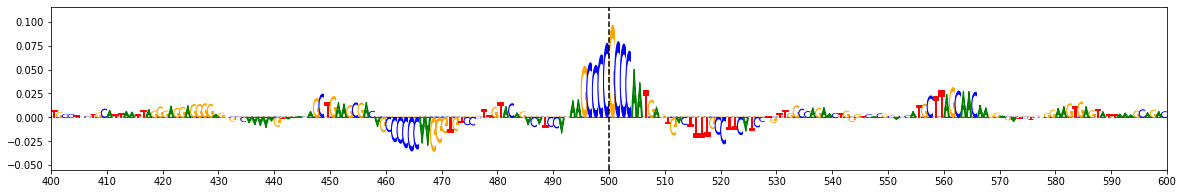

Effect Allele: T   ||   Effect Center: 0.053   ||   Center / 200bp : 0.0676

Effect Motif: GCCCTGCCCAA


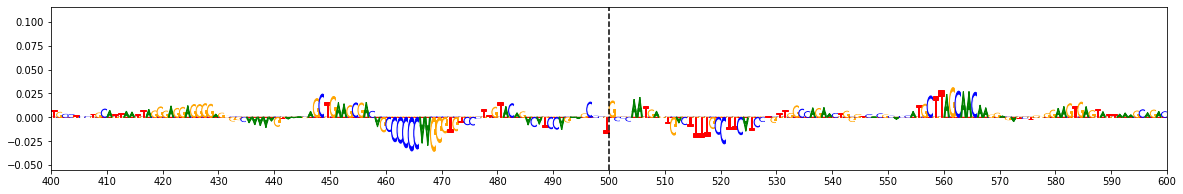

gkmExplain Score: -0.3171  ||  ISM Score: -1.1533  ||  deltaSVM Score: -6.5484

gkmExplain P-Value: 0.002794  ||  ISM P-Value: 0.003049  ||  deltaSVM P-Value: 0.003243

Difference Motif: GCCC(C/T)GCCCAA


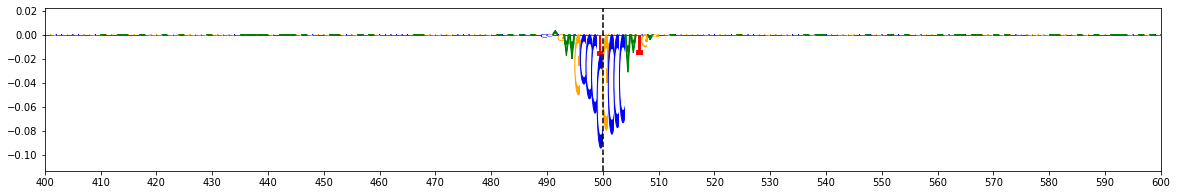



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 160

RSID: rs6781790   ||    chr3 : 49007333 - 49007334   ||    Locus: 92   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 2.3493E-03   ||    Coloc: False   ||    Confidence: 2


Noneffect Allele: C   ||   Noneffect Center: 0.6269   ||   Center / 200bp : 0.2466

Noneffect Motif: GAGGGCGCTGT


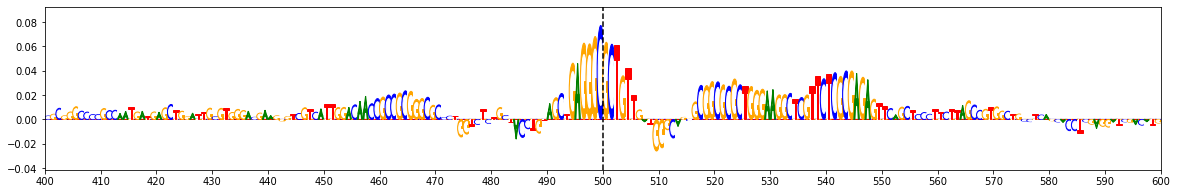

Effect Allele: T   ||   Effect Center: 0.1332   ||   Center / 200bp : 0.0677

Effect Motif: GAGGGTGCTGT


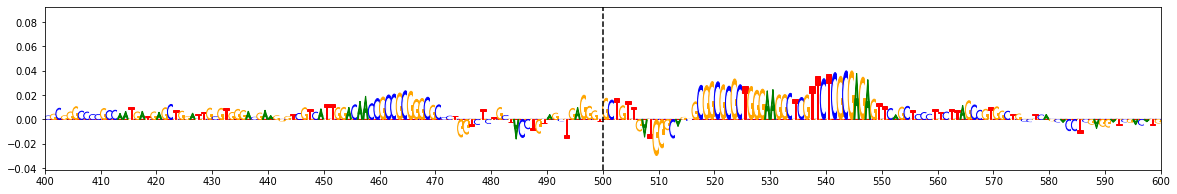

gkmExplain Score: -0.1789  ||  ISM Score: -0.968  ||  deltaSVM Score: -5.6311

gkmExplain P-Value: 0.023043  ||  ISM P-Value: 0.008136  ||  deltaSVM P-Value: 0.007906

Difference Motif: GAGGG(C/T)GCTGT


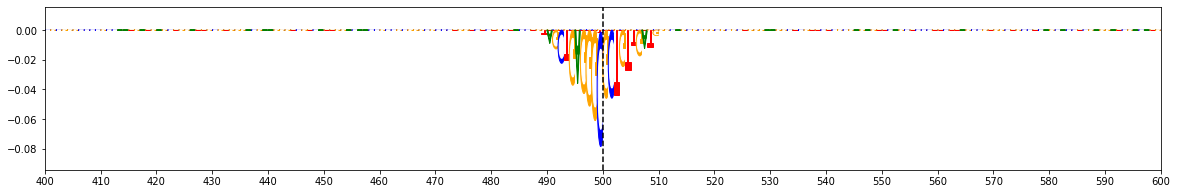



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 128

RSID: rs35194062   ||    chr19 : 45001918 - 45001919   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Kunkle_2019   ||    P-Value: 2.3840E-14   ||    Coloc: True   ||    Confidence: 1


Noneffect Allele: C   ||   Noneffect Center: 0.8878   ||   Center / 200bp : 0.2491

Noneffect Motif: GGGGCGGGGC


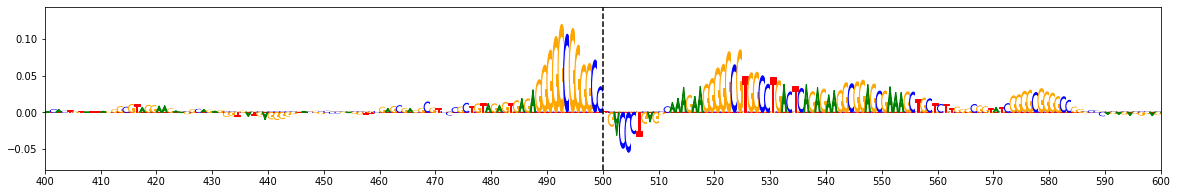

Effect Allele: A   ||   Effect Center: 0.5607   ||   Center / 200bp : 0.1712

Effect Motif: GGGGCGGGGC


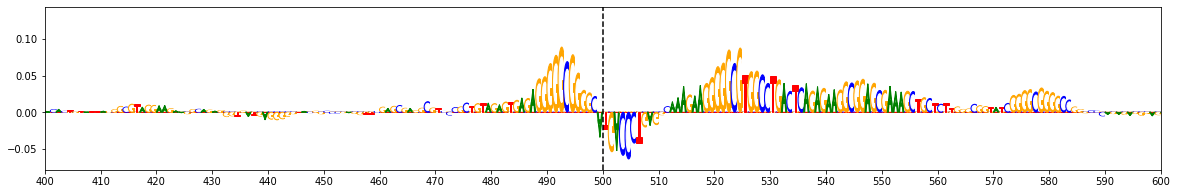

gkmExplain Score: -0.0778  ||  ISM Score: -0.8989  ||  deltaSVM Score: -5.2759

gkmExplain P-Value: 0.202719  ||  ISM P-Value: 0.011897  ||  deltaSVM P-Value: 0.011247

Difference Motif: GGGGCGGGGC(C/A)


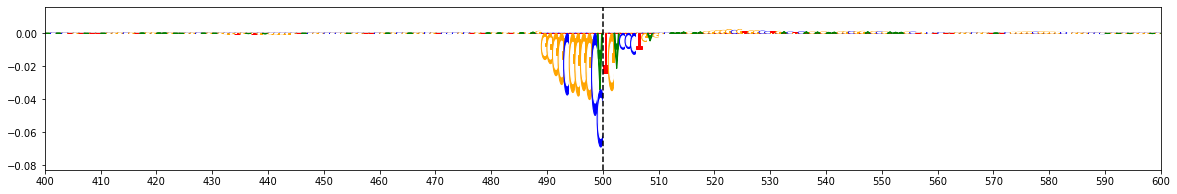



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [18]:
neg_diff_motifs = []

for idx in neg_snps.index:

    print()
    print('Index:', idx)
    print()
    print('RSID:', neg_snps.at[idx, 'rsid'],
          '  ||   ', neg_snps.at[idx, 'chr'], 
          ':', neg_snps.at[idx, 'start'],
          '-', neg_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', neg_snps.at[idx, 'locus_num'],
          '  ||   ', 'IDR Peak:', neg_snps.at[idx, 'idr_peak'])
    print()
    print('GWAS:', neg_snps.at[idx, 'gwas'],
          '  ||   ', 'P-Value:', '%.4E' % Decimal(neg_snps.at[idx, 'gwas_pval']),
          '  ||   ', 'Coloc:', neg_snps.at[idx, 'coloc'], 
          '  ||   ', 'Confidence:', neg_snps.at[idx, 'confidence'])
    print()
    print()
    
    if neg_snps.at[idx, 'noneffect'] != 'NAN':
        print('Noneffect Allele:', neg_snps.at[idx, 'noneffect'],
              '  ||   Noneffect Center:', round(neg_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Noneffect Motif:', neg_snps.at[idx, 'motif'])
    else:
        print('Major Allele:', neg_snps.at[idx, 'major'],
              '  ||   Major Center:', round(neg_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Major Motif:', neg_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_noneffect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(noneffect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    ylim = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, xlim=(400,600))

    if neg_snps.at[idx, 'effect'] != 'NAN':
        print('Effect Allele:', neg_snps.at[idx, 'effect'],
              '  ||   Effect Center:', round(neg_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Effect Motif:', neg_snps.at[idx, 'motif_other'])
    else:
        print('Minor Allele:', neg_snps.at[idx, 'minor'].split(',')[0],
              '  ||   Minor Center:', round(neg_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(neg_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Minor Motif:', neg_snps.at[idx, 'motif_other'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_effect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(effect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    a = plot_weights(merged_effect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('gkmExplain Score:',
          round(neg_snps.at[idx, 'ratio_score'], 4),
          ' ||  ISM Score:', round(neg_snps.at[idx, 'ism_score'], 4),
          ' ||  deltaSVM Score:', round(neg_snps.at[idx, 'delta_score'], 4))
    print()
    print('gkmExplain P-Value:', round(neg_snps.at[idx, 'ratio_pval'], 6),
          ' ||  ISM P-Value:', round(neg_snps.at[idx, 'ism_pval'], 6),
          ' ||  deltaSVM P-Value:', round(neg_snps.at[idx, 'delta_pval'], 6))
    print()
    if neg_snps.at[idx, 'noneffect'] != 'NAN':
        diff_motif = (noneffect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + neg_snps.at[idx, 'noneffect']
                      + '/' + neg_snps.at[idx, 'effect']
                      + ')' + noneffect_seqs[idx][500:sig_list[idx][6]])
    else:
        diff_motif = (noneffect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + neg_snps.at[idx, 'major']
                      + '/' + neg_snps.at[idx, 'minor']
                      + ')' + noneffect_seqs[idx][500:sig_list[idx][6]])
    print('Difference Motif:', diff_motif)
    neg_diff_motifs.append(diff_motif)
    
    a = plot_weights(merged_effect_scores[idx] - merged_noneffect_scores[idx],
                     subticks_frequency=10, xlim=(400,600))
    
    print()
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()
    
neg_snps['diff_motif'] = neg_diff_motifs

# Visualize Top Positive Scoring SNPs <a name='pos_snps' />


Index: 101

RSID: rs10426401   ||    chr19 : 44644418 - 44644419   ||    Locus: 71   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 4.6321E-14   ||    Coloc: True   ||    Confidence: 2


Effect Allele: G   ||   Effect Center: 0.2785   ||   Center / 200bp : 0.1627

Effect Motif: GGGGCGG


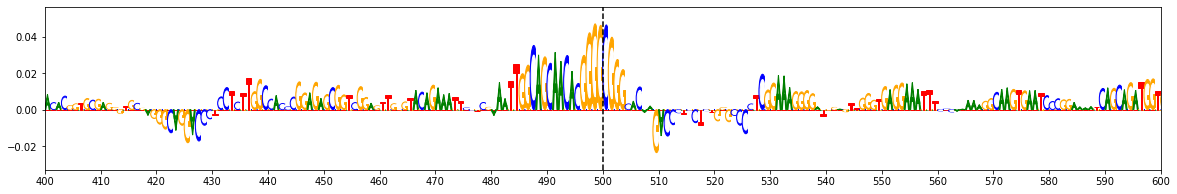

Noneffect Allele: T   ||   Noneffect Center: -0.0192   ||   Center / 200bp : 0.0037

Noneffect Motif: GGGTCGG


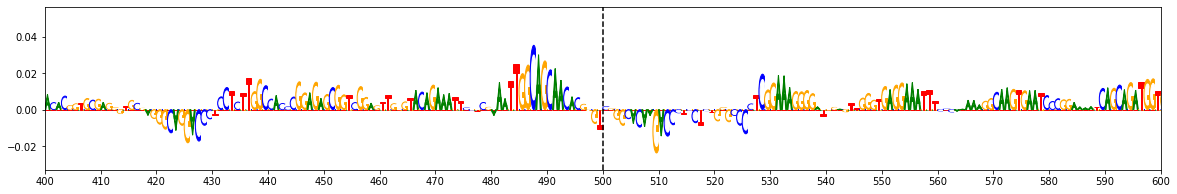

gkmExplain Score: 0.159  ||  ISM Score: 0.7148  ||  deltaSVM Score: 4.1006

gkmExplain P-Value: 0.033806  ||  ISM P-Value: 0.033537  ||  deltaSVM P-Value: 0.036574

Difference Motif: GGG(G/T)CGG


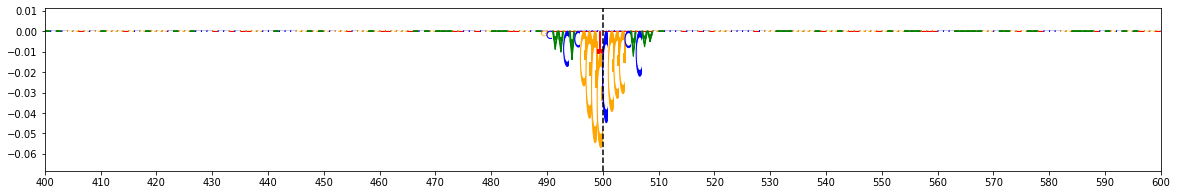



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 196

RSID: rs3735901   ||    chr8 : 22604860 - 22604861   ||    Locus: 125   ||    IDR Peak: True

GWAS: Chang_23andMe_Parkinsons   ||    P-Value: 5.0811E-02   ||    Coloc: False   ||    Confidence: 0


Effect Allele: T   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: CCCCTGCCGC


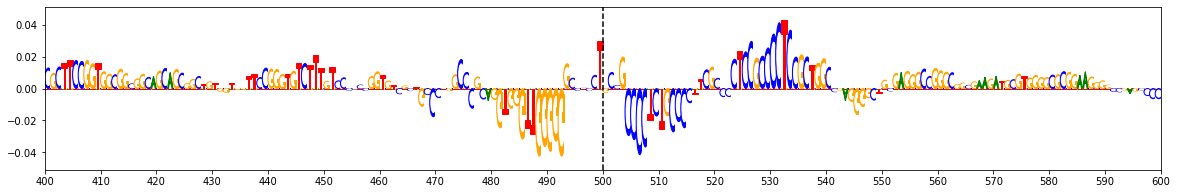

Noneffect Allele: C   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: CCCCCGCCGC


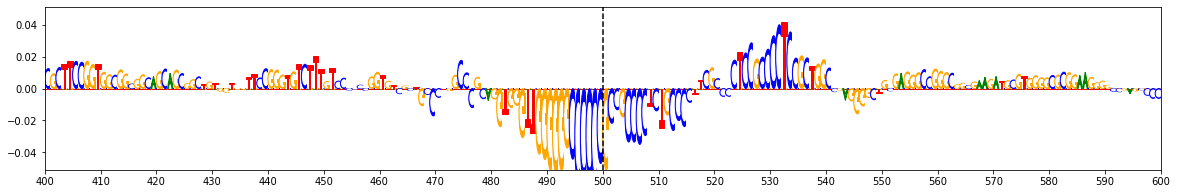

gkmExplain Score: 0.0  ||  ISM Score: 0.91  ||  deltaSVM Score: 5.9221

gkmExplain P-Value: 0.999998  ||  ISM P-Value: 0.011186  ||  deltaSVM P-Value: 0.005939

Difference Motif: CCCC(T/C)GCCGC


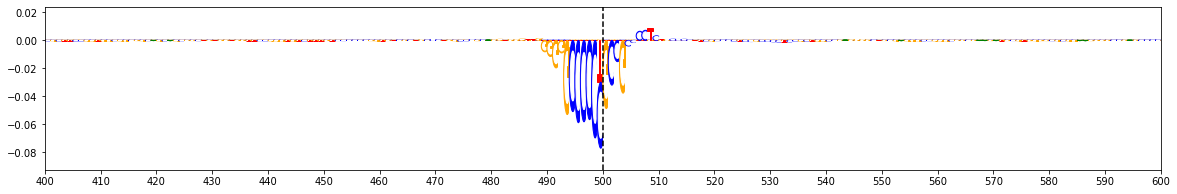



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------



Index: 198

RSID: rs1532276   ||    chr8 : 27608639 - 27608640   ||    Locus: 126   ||    IDR Peak: True

GWAS: Alzheimers_Jansen_2018   ||    P-Value: 4.0000E-19   ||    Coloc: True   ||    Confidence: 0


Effect Allele: T   ||   Effect Center: 0.0   ||   Center / 200bp : 0.0

Effect Motif: CCCATCCAGA


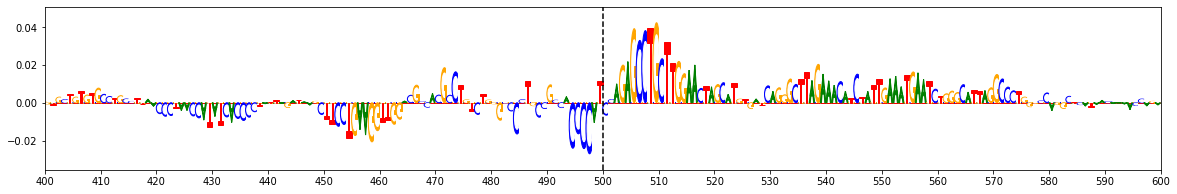

Noneffect Allele: C   ||   Noneffect Center: 0.0   ||   Center / 200bp : 0.0

Noneffect Motif: CCCACCCAGA


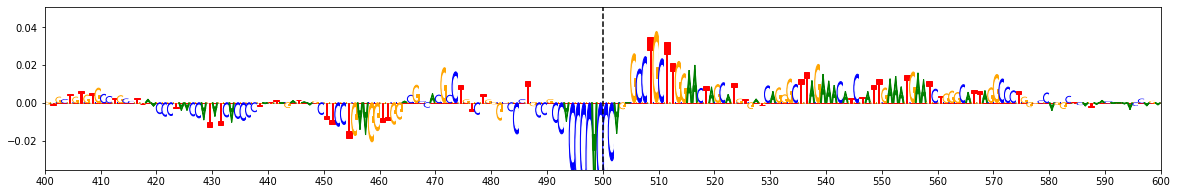

gkmExplain Score: 0.0  ||  ISM Score: 0.6846  ||  deltaSVM Score: 3.9549

gkmExplain P-Value: 0.999998  ||  ISM P-Value: 0.039812  ||  deltaSVM P-Value: 0.042316

Difference Motif: CCCA(T/C)CCAGA


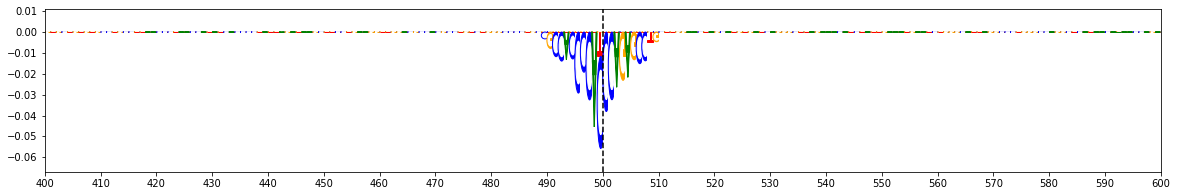



--------------------------------------------------------------------------------
--------------------------------------------------------------------------------




In [19]:
pos_diff_motifs = []

for idx in pos_snps.index:

    print()
    print('Index:', idx)
    print()
    print('RSID:', pos_snps.at[idx, 'rsid'],
          '  ||   ', pos_snps.at[idx, 'chr'], 
          ':', pos_snps.at[idx, 'start'],
          '-', pos_snps.at[idx, 'end'],
          '  ||   ', 'Locus:', pos_snps.at[idx, 'locus_num'],
          '  ||   ', 'IDR Peak:', pos_snps.at[idx, 'idr_peak'])
    print()
    print('GWAS:', pos_snps.at[idx, 'gwas'],
          '  ||   ', 'P-Value:', '%.4E' % Decimal(pos_snps.at[idx, 'gwas_pval']),
          '  ||   ', 'Coloc:', pos_snps.at[idx, 'coloc'], 
          '  ||   ', 'Confidence:', pos_snps.at[idx, 'confidence'])
    print()
    print()
    
    if pos_snps.at[idx, 'effect'] != 'NAN':
        print('Effect Allele:', pos_snps.at[idx, 'effect'],
              '  ||   Effect Center:', round(pos_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Effect Motif:', pos_snps.at[idx, 'motif'])
    else:
        print('Minor Allele:', pos_snps.at[idx, 'minor'].split(',')[0],
              '  ||   Minor Center:', round(pos_snps.at[idx, 'effect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'effect_ratio'], 4))
        print()
        print('Minor Motif:', pos_snps.at[idx, 'motif'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_effect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(effect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    ylim = plot_weights(merged_effect_scores[idx], subticks_frequency=10, xlim=(400,600))

    if pos_snps.at[idx, 'noneffect'] != 'NAN':
        print('Noneffect Allele:', pos_snps.at[idx, 'noneffect'],
              '  ||   Noneffect Center:', round(pos_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Noneffect Motif:', pos_snps.at[idx, 'motif_other'])
    else:
        print('Major Allele:', pos_snps.at[idx, 'major'],
              '  ||   Major Center:', round(pos_snps.at[idx, 'noneffect_center'], 4),
              '  ||   Center / 200bp :', round(pos_snps.at[idx, 'noneffect_ratio'], 4))
        print()
        print('Major Motif:', pos_snps.at[idx, 'motif_other'])
        
#     print()
#     print(t.cdf([np.sum(j) for j in merged_noneffect_scores[idx][485:515]],
#                 sig_list[idx][2], sig_list[idx][3], sig_list[idx][4]))
#     print()
#     print(noneffect_seqs[idx][sig_list[idx][0]:sig_list[idx][1]])
    
    a = plot_weights(merged_noneffect_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    
    print('gkmExplain Score:',
          round(pos_snps.at[idx, 'ratio_score'], 4),
          ' ||  ISM Score:', round(pos_snps.at[idx, 'ism_score'], 4),
          ' ||  deltaSVM Score:', round(pos_snps.at[idx, 'delta_score'], 4))
    print()
    print('gkmExplain P-Value:', round(pos_snps.at[idx, 'ratio_pval'], 6),
          ' ||  ISM P-Value:', round(pos_snps.at[idx, 'ism_pval'], 6),
          ' ||  deltaSVM P-Value:', round(pos_snps.at[idx, 'delta_pval'], 6))
    print()
    if pos_snps.at[idx, 'effect'] != 'NAN':
        diff_motif = (effect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + pos_snps.at[idx, 'effect']
                      + '/' + pos_snps.at[idx, 'noneffect']
                      + ')' + effect_seqs[idx][500:sig_list[idx][6]])
        print('Difference Motif:', diff_motif)
    else:
        diff_motif = (effect_seqs[idx][sig_list[idx][5]:499]
                      + '(' + pos_snps.at[idx, 'minor']
                      + '/' + pos_snps.at[idx, 'major']
                      + ')' + effect_seqs[idx][500:sig_list[idx][6]])
        print('Difference Motif:', diff_motif)
    pos_diff_motifs.append(diff_motif)
    
    a = plot_weights(merged_noneffect_scores[idx] - merged_effect_scores[idx],
                     subticks_frequency=10, xlim=(400,600))
    
    print()
    print()
    print('-'*80)
    print('-'*80)
    print()
    print()
    
pos_snps['diff_motif'] = pos_diff_motifs

# Generate Signal Tracks

In [20]:
clust_to_celltype = {1: 'excitatory_neurons', 
                     2: 'inhibitory_neurons',
                     3: 'excitatory_neurons',
                     4: 'excitatory_neurons',
                     5: 'nigral_neurons',
                     6: 'nigral_neurons',
                     7: 'unknown_neurons',
                     8: 'opcs',
                     9: 'opcs',
                     10: 'opcs',
                     11: 'inhibitory_neurons',
                     12: 'inhibitory_neurons',
                     13: 'astrocytes',
                     14: 'astrocytes',
                     15: 'astrocytes',
                     16: 'astrocytes',
                     17: 'astrocytes',
                     18: 'doublets',
                     19: 'oligodendrocytes',
                     20: 'oligodendrocytes',
                     21: 'oligodendrocytes',
                     22: 'oligodendrocytes',
                     23: 'oligodendrocytes',
                     24: 'microglia'}

celltype = clust_to_celltype[cluster_input]

sig_snps = neg_snps.append(pos_snps)
tomtom = ['---' for x in range(len(sig_snps))]
fc_tracks = []
pval_tracks = []
tfactors = ['---' for x in range(len(sig_snps))]
annotations = ['---' for x in range(len(sig_snps))]

for index, row in sig_snps.iterrows():
    chrom = row['chr']
    start = row['start'] - 2500
    end = row['end'] + 2500
    rsid = row['rsid']
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/fc_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snp_fc_signal_tracks/{rsid}.fc.png
    ! pyGenomeTracks --tracks /mnt/lab_data3/soumyak/adpd/pytracks/pval_bigwig_snps.ini --region {chrom}:{start}-{end} -o /oak/stanford/groups/akundaje/projects/alzheimers_parkinsons/snp_pval_signal_tracks/{rsid}.pval.png
    fc_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/snp_fc_signal_tracks/'+rsid+'.fc.png')
    pval_tracks.append('http://mitra.stanford.edu/kundaje/projects/alzheimers_parkinsons/snp_pval_signal_tracks/'+rsid+'.pval.png')
        
sig_snps['tomtom'] = tomtom
sig_snps['fc_track'] = fc_tracks
sig_snps['pval_track'] = pval_tracks
sig_snps['tfactor'] = tfactors
sig_snps['annotation'] = annotations

sig_snps = sig_snps[['chr', 'start', 'end', 'rsid',
                     'effect', 'noneffect', 'direction',
                     'locus_num', 'gwas', 'gwas_pval', 'coloc',
                     'idr_peak', 'ism_pval', 'delta_pval', 'ratio_pval',
                     'confidence', 'motif', 'diff_motif', 'tomtom', 'fc_track',
                     'pval_track', 'tfactor', 'annotation']]

sig_snps.rename(columns = {'ratio_pval': 'explain_pval'}, inplace=True)
sig_snps.sort_values(by=['explain_pval'], ascending=True, inplace=True)

INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.048499107360839844
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting

INFO:pygenometracks.tracksClass:plotting 36. [spacer]
INFO:pygenometracks.tracksClass:plotting 37. [cluster19]
INFO:pygenometracks.tracksClass:plotting 38. [spacer]
INFO:pygenometracks.tracksClass:plotting 39. [cluster20]
INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pyge

INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometracks.tracksClass:plotting 20. [spacer]
INFO:pygenometracks.tracksClass:plotting 21. [cluster11]
INFO:pygenometracks.tracksClass:plotting 22. [spacer]
INFO:pygenometracks.tracksClass:plotting 23. [cluster12]
INFO:pygenometracks.tracksClass:plotting 24. [spacer]
INFO:pygenometracks.tracksClass:plotting 25. [cluster13]
INFO:pygenometracks.tracksClass:plotting 26. [spacer]
INFO:pygenometracks.tracksClass:plotting 27. [cluster14]
INFO:pygenometracks.tracksClass:plotting 28. [spacer]
INFO:pygenometracks.tracksClass:plotting 29. [cluster15]
INFO:pygenometracks.tracksClass:plotting 30. [spacer]
INFO:pygenometracks.tracksClass:plotting 31. [cluster16]
INFO:pygenometracks.tracksClass:plotting 32. [spacer]
INFO:pygenometracks.tracksClass:plotting 33. [cluster17]
INFO:pygenometracks.tracksClass:plotting 34. [spacer]
INFO:pygenometracks.tracksClass:plotting 35. [cluster18]
INFO:pygenometracks.tracksClass:plotting 36. [spacer]
I

INFO:pygenometracks.tracksClass:plotting 2. [spacer]
INFO:pygenometracks.tracksClass:plotting 3. [cluster2]
INFO:pygenometracks.tracksClass:plotting 4. [spacer]
INFO:pygenometracks.tracksClass:plotting 5. [cluster3]
INFO:pygenometracks.tracksClass:plotting 6. [spacer]
INFO:pygenometracks.tracksClass:plotting 7. [cluster4]
INFO:pygenometracks.tracksClass:plotting 8. [spacer]
INFO:pygenometracks.tracksClass:plotting 9. [cluster5]
INFO:pygenometracks.tracksClass:plotting 10. [spacer]
INFO:pygenometracks.tracksClass:plotting 11. [cluster6]
INFO:pygenometracks.tracksClass:plotting 12. [spacer]
INFO:pygenometracks.tracksClass:plotting 13. [cluster7]
INFO:pygenometracks.tracksClass:plotting 14. [spacer]
INFO:pygenometracks.tracksClass:plotting 15. [cluster8]
INFO:pygenometracks.tracksClass:plotting 16. [spacer]
INFO:pygenometracks.tracksClass:plotting 17. [cluster9]
INFO:pygenometracks.tracksClass:plotting 18. [spacer]
INFO:pygenometracks.tracksClass:plotting 19. [cluster10]
INFO:pygenometrac

INFO:pygenometracks.tracksClass:plotting 40. [spacer]
INFO:pygenometracks.tracksClass:plotting 41. [cluster21]
INFO:pygenometracks.tracksClass:plotting 42. [spacer]
INFO:pygenometracks.tracksClass:plotting 43. [cluster22]
INFO:pygenometracks.tracksClass:plotting 44. [spacer]
INFO:pygenometracks.tracksClass:plotting 45. [cluster23]
INFO:pygenometracks.tracksClass:plotting 46. [spacer]
INFO:pygenometracks.tracksClass:plotting 47. [cluster24]
INFO:pygenometracks.tracksClass:plotting 48. [spacer]
INFO:pygenometracks.tracksClass:plotting 49. [snps]
DEBUG:pygenometracks.tracks.GenomeTrack:ylim 100,0
INFO:pygenometracks.tracksClass:plotting 50. [spacer]
INFO:pygenometracks.tracksClass:plotting 51. [x-axis]
INFO:pygenometracks.tracksClass:time initializing track(s):
INFO:pygenometracks.tracksClass:0.05172538757324219
DEBUG:pygenometracks.tracksClass:Figure size in cm is 40 x 114.375. Dpi is set to 72

INFO:pygenometracks.tracksClass:plotting 1. [cluster1]
INFO:pygenometracks.tracksClass:plotti

# Save Significant SNPs

In [21]:
sig_snps.to_csv('/mnt/lab_data3/soumyak/adpd/sig_snps/Cluster'
                + cluster
                + '.'
                + celltype
                + '.snps.csv',
                sep='\t', index=False)

# Final SNP Table <a name='final_table' />

In [22]:
display(sig_snps)

,chr,start,end,rsid,effect,noneffect,direction,locus_num,gwas,gwas_pval,coloc,idr_peak,ism_pval,delta_pval,explain_pval,confidence,motif,diff_motif,tomtom,fc_track,pval_track,tfactor,annotation
148,chr2,127128581,127128582,rs13025717,T,C,+,77,Alzheimers_Jansen_2018,9.125833e-17,False,True,0.003049,0.003243,0.002794,2,GCCCCGCCCAA,GCCC(C/T)GCCCAA,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
160,chr3,49007333,49007334,rs6781790,T,C,+,92,Chang_23andMe_Parkinsons,2.349340e-03,False,True,0.008136,0.007906,0.023043,2,GAGGGCGCTGT,GAGGG(C/T)GCTGT,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
101,chr19,44644418,44644419,rs10426401,G,T,-,71,Alzheimers_Jansen_2018,4.632150e-14,True,True,0.033537,0.036574,0.033806,2,GGGGCGG,GGG(G/T)CGG,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
128,chr19,45001918,45001919,rs35194062,A,C,+,71,Alzheimers_Kunkle_2019,2.384000e-14,True,True,0.011897,0.011247,0.202719,1,GGGGCGGGGC,GGGGCGGGGC(C/A),---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
196,chr8,22604860,22604861,rs3735901,T,C,-,125,Chang_23andMe_Parkinsons,5.081120e-02,False,True,0.011186,0.005939,0.999998,0,CCCCTGCCGC,CCCC(T/C)GCCGC,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
198,chr8,27608639,27608640,rs1532276,T,C,-,126,Alzheimers_Jansen_2018,4.000015e-19,True,True,0.039812,0.042316,0.999998,0,CCCATCCAGA,CCCA(T/C)CCAGA,---,http://mitra.stanford.edu/kundaje/projects/alz...,http://mitra.stanford.edu/kundaje/projects/alz...,---,---
